In [1]:
import scipy as sp
import scipy.integrate as spint8
import os,sys
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen; from GWGen import WFGenerator
import pyAnalyticFluxes as pyan
from GWGen.WFGenerator import *
from few.utils.utility import get_separatrix
from few.trajectory.inspiral import EMRIInspiral
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyAnalyticFluxes as pyan
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# set initial parameters
M = 1e5
m = 1e1
mu = 4e-16
a = 0.9
p0 = 10.0
e0 = 0.2
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.8
qK = 0.2
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 10.0

alphaval = alphavalue(M,mu)
print(r"alpha = {0}".format(alphaval))


use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "npoints": 100,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "dense_output":False
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

traj = PNTraj()
pc =ProcaSolution(M,a,mu)
    
deltaC = pc.ChangeInOrbitalConstants(SecondaryMass=m, SMBHMass=M)
few_traj = EMRIInspiral(func="pn5")

def IncreaseArrayDensity(arr, npoints):
    assert len(arr)<=npoints, "Error: npoints must be equal to or larger than length of input array"
    if npoints>len(arr):
        newarr = [arr[0]]
        remainder = npoints*len(arr)
        for inx, i in enumerate(arr):
            if inx<len(arr)-1:
                newintpnts = int(floor(npoints/len(arr)))+1
                newsec = np.linspace(arr[inx], arr[inx+1], newintpnts)[1:]
                _=[newarr.append(i) for i in newsec]
        remainderpoints=npoints-len(newarr)
        arrend = newarr[-remainderpoints:]
        arrendavgs = 1/2*(np.array(arrend)[1:] + np.array(arrend)[:-1])
        newarrend = []
        for i in range(len(arrend) + len(arrendavgs)):
            if i%2 == 0:
                newarrend.append(arrend[int(i/2)])
            if i%2 == 1:
                newarrend.append(arrendavgs[int((i-1)/2)])
        newarr = newarr[:-remainderpoints-1]
        _=[newarr.append(i) for i in newarrend]
        return newarr
    elif npoints==len(arr):
        return arr

alpha = 0.29932552246288896
UltralightBoson instance not provided. Instantiating class...
done.


[0.00000000e+00 3.04270974e-02 3.34698071e-01 3.37740781e+00
 3.38045052e+01 3.38075479e+02 3.38078522e+03 3.38078826e+04
 3.38078857e+05 1.45432161e+06 1.85706733e+06 1.95169176e+06
 1.99696338e+06 2.02162049e+06 2.02792459e+06 2.02957893e+06
 2.02996410e+06 2.03006925e+06]
[0.00000000e+00 3.04270974e-02 3.34698071e-01 3.37740781e+00
 3.38045052e+01 3.38075479e+02 3.38078522e+03 3.38078826e+04
 3.38078857e+05 1.49413551e+06 1.82244134e+06 1.94779734e+06
 1.98667937e+06 2.00275891e+06 2.00677840e+06 2.00895095e+06
 2.00958146e+06 2.00976864e+06 2.00981623e+06 2.00982648e+06
 2.00982973e+06 2.00983298e+06 2.00983601e+06 2.00983788e+06
 2.00983909e+06 2.00984029e+06 2.00984068e+06 2.00984099e+06
 2.00984127e+06 2.00984404e+06 2.00987181e+06 2.01014945e+06
 2.01292586e+06 2.04068997e+06 2.20555411e+06 2.27342761e+06
 2.28952180e+06 2.29404085e+06 2.29520986e+06 2.29548396e+06
 2.29555152e+06]
exit reason Separatrix reached!    last p 2.3223953476498282


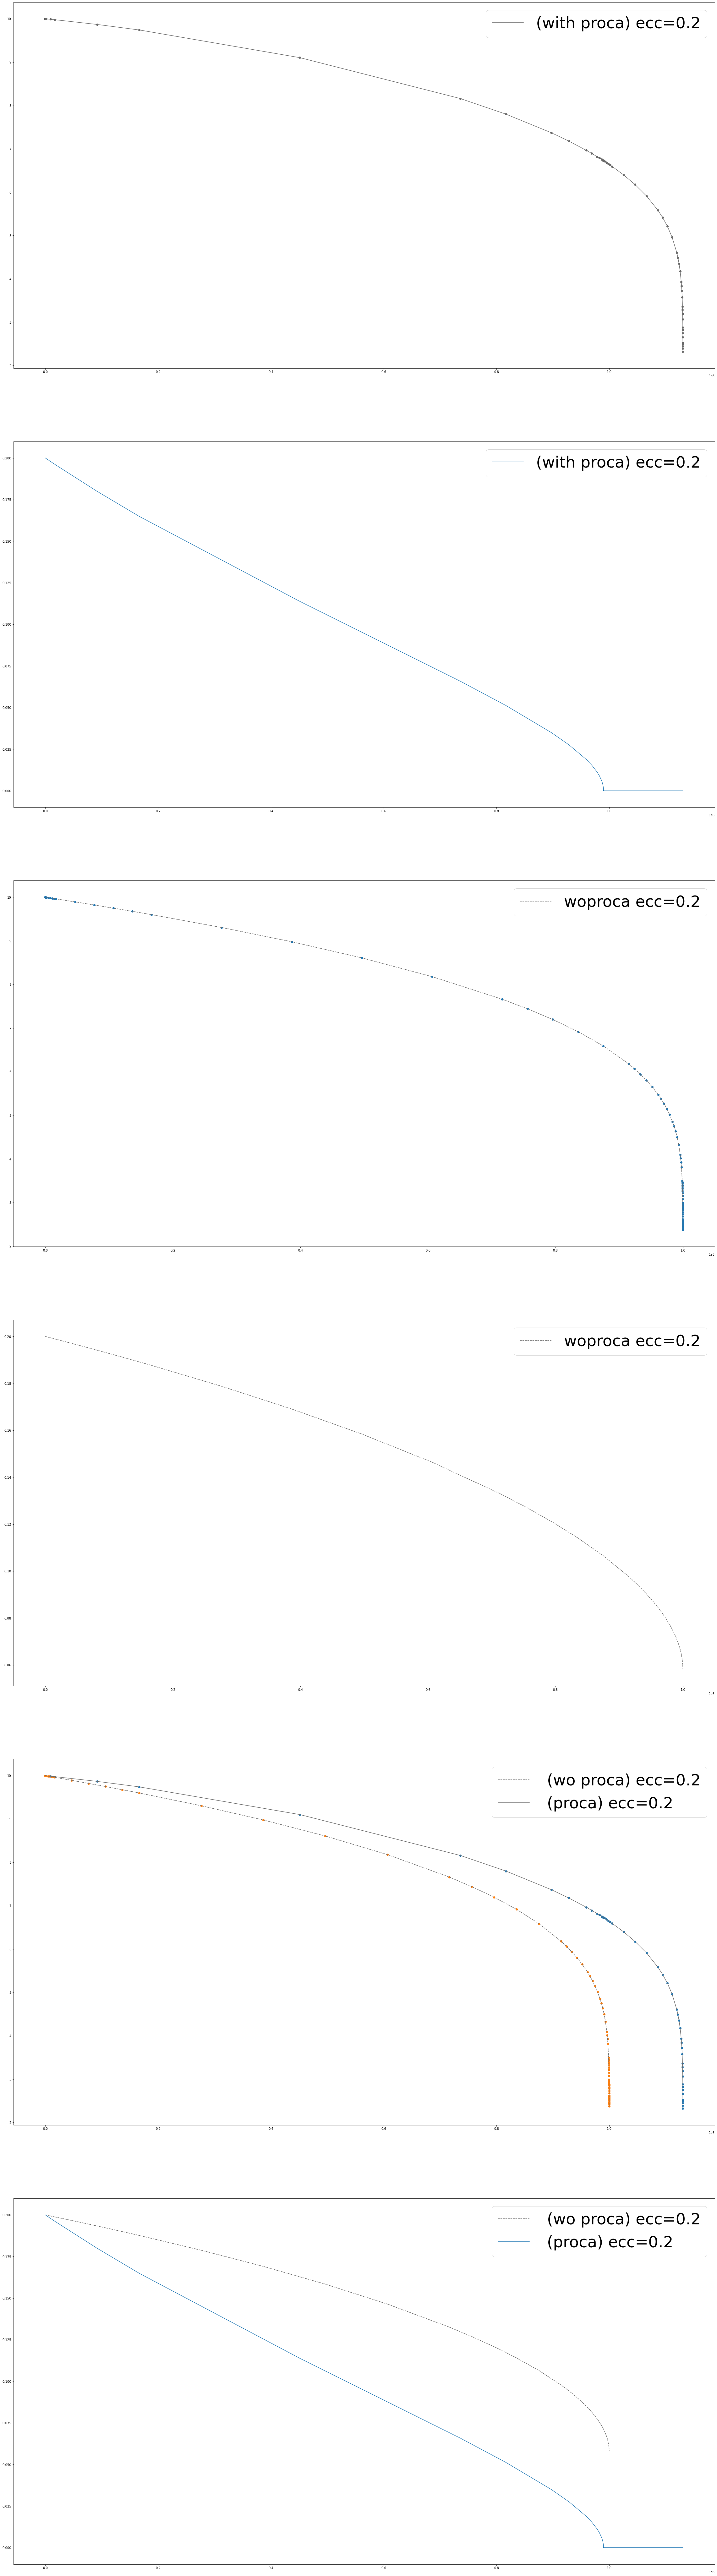

In [2]:
inspiral_kwargs["dense_output"]=True
traj.separatrix_cutoff = get_separatrix(a,e0,1.)+0.01
fig,axes = plt.subplots(6,1,figsize=(40,150))
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.CSS4_COLORS.items())
cols = [name for hsv, name in by_hsv]

inx=1
ec = e0
#few
fewres = traj(M,m,a,p0,ec,Y0,T=T,**inspiral_kwargs)
axes[2].plot(fewres[0], fewres[1], label="woproca ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[2].scatter(fewres[0], fewres[1])
axes[2].legend(fontsize=50)
axes[3].plot(fewres[0], fewres[2], label="woproca ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[3].legend(fontsize=50)

#mine
res = traj(M,m,a,p0,ec,Y0,T=T, DeltaEFlux = deltaC["E"], DeltaLFlux = deltaC["L"], **inspiral_kwargs)
print("exit reason {0}    last p {1}".format(traj.exit_reason, res[1][-1]))
t,p,e = res[0:3]
axes[0].plot(t,p,label="(with proca) ecc={0}".format(ec),color=cols[inx])
axes[0].scatter(t,p,color=cols[inx])
axes[1].plot(t,e,label="(with proca) ecc={0}".format(ec))
axes[0].legend(labelcolor="Black",fontsize=50)
axes[1].legend(fontsize=50)

axes[4].plot(fewres[0], fewres[1], label=" (wo proca) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[4].plot(t,p,label=" (proca) ecc={0}".format(ec),color=cols[inx])
axes[4].scatter(t,p)
axes[4].scatter(fewres[0], fewres[1])
axes[5].plot(fewres[0], fewres[2], label=" (wo proca) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[5].plot(t,e,label=" (proca) ecc={0}".format(ec))
axes[4].legend(fontsize=50)
axes[5].legend(fontsize=50);

restrue = res
fewrestrue = fewres

[0.00000000e+00 3.04270974e-02 3.34698071e-01 3.37740781e+00
 3.38045052e+01 3.38075479e+02 3.38078522e+03 3.38078826e+04
 3.38078857e+05 1.45432161e+06 1.85706733e+06 1.95169176e+06
 1.99696338e+06 2.02162049e+06 2.02792459e+06 2.02957893e+06
 2.02996410e+06 2.03006925e+06]
[0.00000000e+00 3.04270974e-02 3.34698071e-01 3.37740781e+00
 3.38045052e+01 3.38075479e+02 3.38078522e+03 3.38078826e+04
 3.38078857e+05 1.49413551e+06 1.82244134e+06 1.94779734e+06
 1.98667937e+06 2.00275891e+06 2.00677840e+06 2.00895095e+06
 2.00958146e+06 2.00976864e+06 2.00981623e+06 2.00982648e+06
 2.00982973e+06 2.00983298e+06 2.00983601e+06 2.00983788e+06
 2.00983909e+06 2.00984029e+06 2.00984068e+06 2.00984099e+06
 2.00984127e+06 2.00984404e+06 2.00987181e+06 2.01014945e+06
 2.01292586e+06 2.04068997e+06 2.20555411e+06 2.27342761e+06
 2.28952180e+06 2.29404085e+06 2.29520986e+06 2.29548396e+06
 2.29555152e+06]
exit reason Separatrix reached!    last p 2.3223953476498282


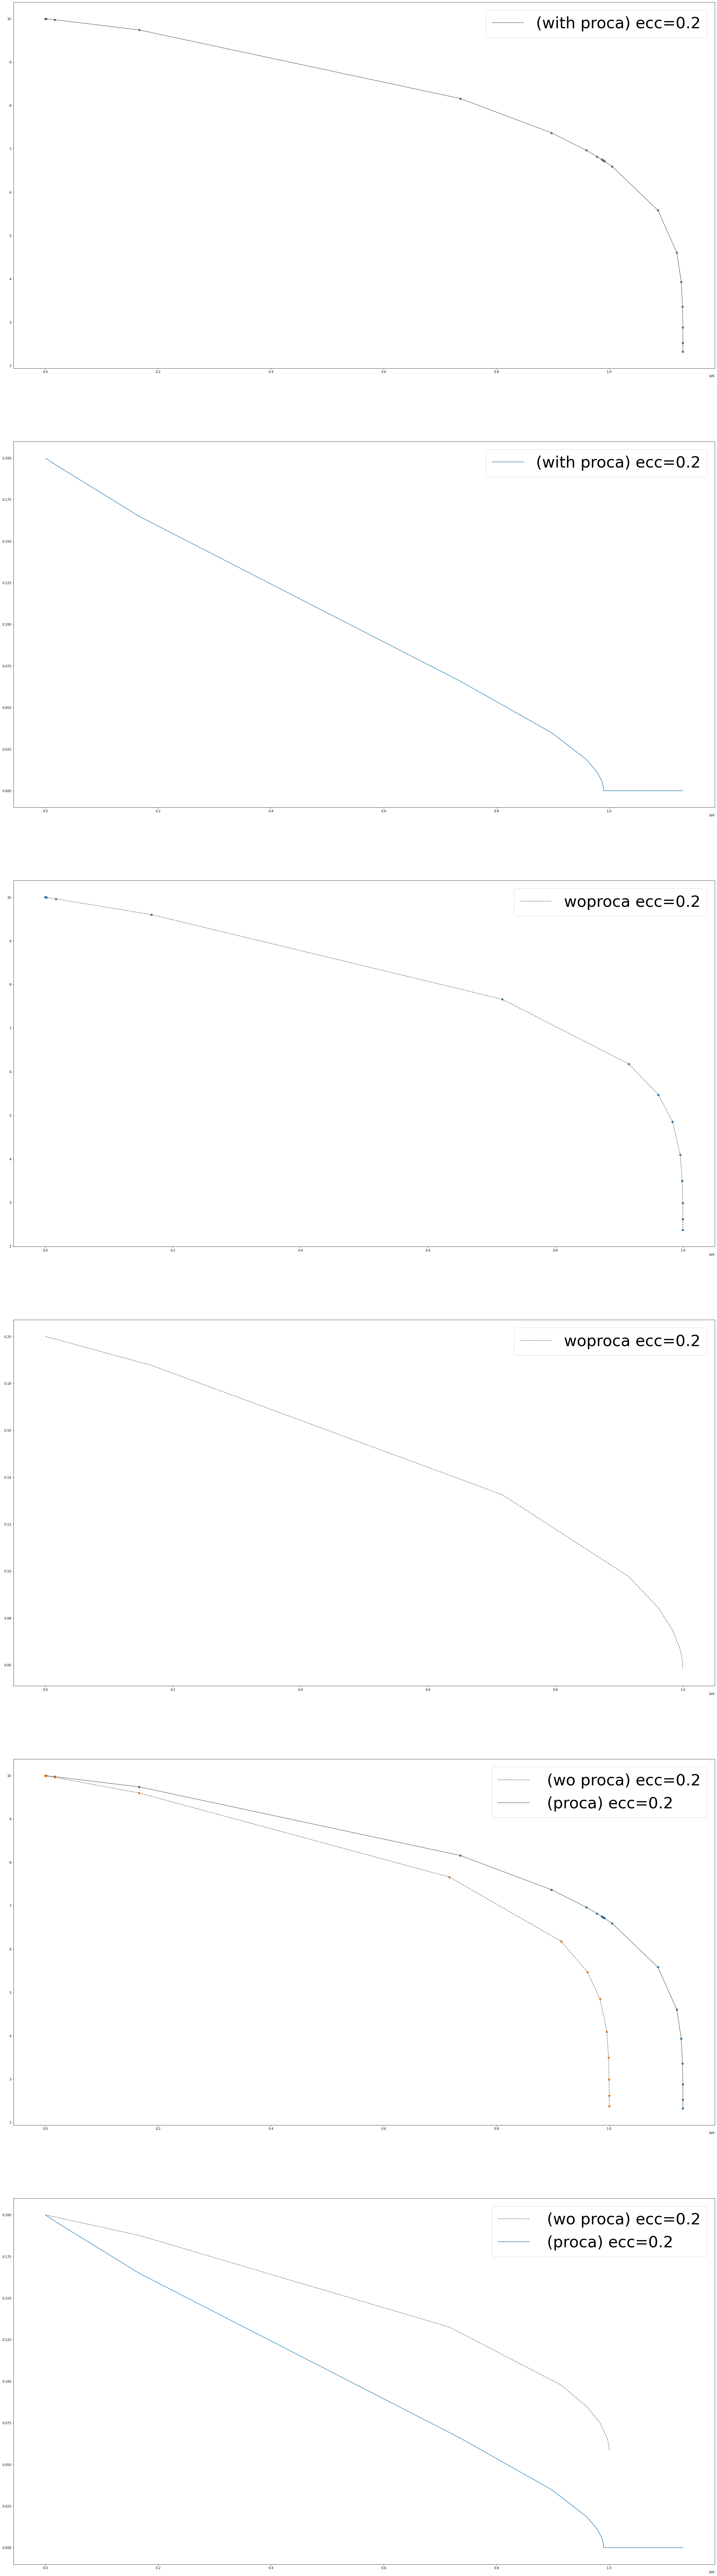

In [3]:
inspiral_kwargs["dense_output"]=False
traj.separatrix_cutoff = get_separatrix(a,e0,1.)+0.01
fig,axes = plt.subplots(6,1,figsize=(40,150))
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.CSS4_COLORS.items())
cols = [name for hsv, name in by_hsv]

inx=1
ec = e0
#few
fewres = traj(M,m,a,p0,ec,Y0,T=T,**inspiral_kwargs)
axes[2].plot(fewres[0], fewres[1], label="woproca ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[2].scatter(fewres[0], fewres[1])
axes[2].legend(fontsize=50)
axes[3].plot(fewres[0], fewres[2], label="woproca ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[3].legend(fontsize=50)

#mine
res = traj(M,m,a,p0,ec,Y0,T=T, DeltaEFlux = deltaC["E"], DeltaLFlux = deltaC["L"], **inspiral_kwargs)
print("exit reason {0}    last p {1}".format(traj.exit_reason, res[1][-1]))
t,p,e = res[0:3]
axes[0].plot(t,p,label="(with proca) ecc={0}".format(ec),color=cols[inx])
axes[0].scatter(t,p,color=cols[inx])
axes[1].plot(t,e,label="(with proca) ecc={0}".format(ec))
axes[0].legend(labelcolor="Black",fontsize=50)
axes[1].legend(fontsize=50)

axes[4].plot(fewres[0], fewres[1], label=" (wo proca) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[4].plot(t,p,label=" (proca) ecc={0}".format(ec),color=cols[inx])
axes[4].scatter(t,p)
axes[4].scatter(fewres[0], fewres[1])
axes[5].plot(fewres[0], fewres[2], label=" (wo proca) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[5].plot(t,e,label=" (proca) ecc={0}".format(ec))
axes[4].legend(fontsize=50)
axes[5].legend(fontsize=50);

resfalse = res
fewresfalse = fewres

len(fewrestrue) = 100
len(fewresfalse) = 18


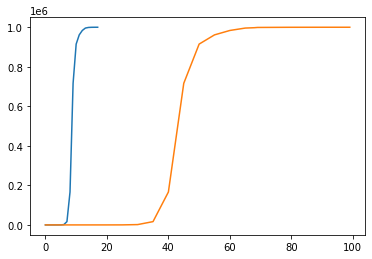

In [4]:
print("len(fewrestrue) = {0}".format(len(fewrestrue[0])))
print("len(fewresfalse) = {0}".format(len(fewresfalse[0])))
plt.plot(fewresfalse[0])
plt.plot(fewrestrue[0])

len(restrue) = 100
len(resfalse) = 41


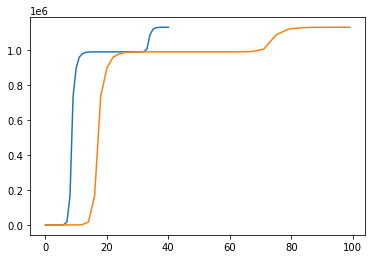

In [5]:
print("len(restrue) = {0}".format(len(restrue[0])))
print("len(resfalse) = {0}".format(len(resfalse[0])))
plt.plot(resfalse[0])
plt.plot(restrue[0])

In [58]:
def tmpextend(arr,npoints):
    assert len(arr)<=npoints, "Error: npoints must be equal to or larger than length of input array"
    if npoints>len(arr):
        newarr = [arr[0]]
        remainder = npoints*len(arr)
        for inx, i in enumerate(arr):
            if inx<len(arr)-1:
                newintpnts = int(floor(npoints/len(arr)))+1
                newsec = np.linspace(arr[inx], arr[inx+1], newintpnts)[1:]
                _=[newarr.append(i) for i in newsec]
        remainderpoints=npoints-len(newarr)
        arrend = newarr[-remainderpoints-2:]
        arrendavgs = 1/2*(np.array(arrend)[1:] + np.array(arrend)[:-1])
        newarrend = []
        for i in range(len(arrend) + len(arrendavgs)):
            if i%2 == 0:
                newarrend.append(arrend[int(i/2)])
            if i%2 == 1:
                newarrend.append(arrendavgs[int((i-1)/2)])
        newarr = newarr[:-remainderpoints-3]
        _=[newarr.append(i) for i in newarrend]
        return newarr
    elif npoints==len(arr):
        return arr


10
44


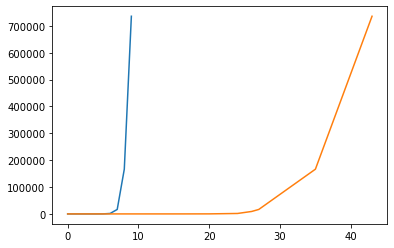

In [59]:
orig = resfalse[0][:10]
new = tmpextend(orig, 44)
print(len(orig))
print(len(new))
plt.plot(orig)
plt.plot(new)

In [56]:
e0=0.2
p0=10
y0=[p0,e0,0,0,0]
npoints=100

fun = PN(M,m, DeltaEFlux = deltaC["E"], DeltaLFlux = deltaC["L"])
t_start = 0
t_stop = 11* YRSID_SI / (M * MTSUN_SI)
t_res = t_stop/npoints
t_span = (t_start, t_stop)
t_dom = np.arange(t_start, t_stop, t_res)
max_step_size = t_span[-1]/npoints
init_sep = get_separatrix(0.9,e0,1.)
fun.separatrix_cutoff = get_separatrix(a,e0,1.)+0.1

class event_holder:
    pass
holder = event_holder()
holder.exit_reason=None

def __integration_event_tracker_eccentricity(_, y_vec):
    ecc = y_vec[1]
    #define a function which is has a zero at e=1, a zero at the smallest negative float, and positive on the range [0,1)
    eps = np.finfo(float).eps
    x_shift = (1-eps**2)/(2*(eps+1))
    y_shift = (eps+x_shift)**2
    res = y_shift - (ecc-x_shift)**2
    #if res<=0:
      #  holder.exit_reason = "Eccentricity exceeded bounds"
    return 1

def __integration_event_tracker_semilatus_rectum(_, y_vec):
    p = y_vec[0]
    res = p-fun.separatrix_cutoff
    if res<=0:
        holder.exit_reason = "Separatrix reached!"
    return res

def __integration_event_tracker_pFlux(_, y_vec):
    Eflux =fun.UndressedpFlux(y_vec[1],y_vec[0])
    res = -Eflux
    if res<=0:
        holder.exit_reason="PN p flux larger than zero! Breaking."
    return res
def __integration_event_tracker_eFlux(_, y_vec):
    p,e = y_vec[:2]
    if e<10**(-10):
        Lflux=0
    else:
        Lflux = fun.UndressedeFlux(e,p)
    res = -Lflux
    if res<0:
        holder.exit_reason="PN e flux larger than zero! Breaking."
    if e==0:
        return np.finfo(float).eps
    return res

__integration_event_tracker_eccentricity.terminal=True
__integration_event_tracker_semilatus_rectum.terminal=True
__integration_event_tracker_pFlux.terminal=True
__integration_event_tracker_eFlux.terminal=True

__integration_event_trackers = [__integration_event_tracker_eccentricity,
                                                        __integration_event_tracker_semilatus_rectum,
                                                        __integration_event_tracker_pFlux]

res=solve_ivp(fun, t_span, y0, method="DOP853",events = __integration_event_trackers)


t = res["t"]
p,e,phiphi,phitheta,phir = res["y"]
x=np.ones_like(p)

In [57]:
len(t)

40

In [16]:
M = 1e5
m = 1e1
a = 0.9
p0 = 10.0
e0 = 0.3
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2

inspiralkwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "npoints":100,
    "dense_output":True
}

# keyword arguments for summation generator (AAKSummation)
sumkwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

MYwfgen = EMRIWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)
PROCAwfgen = EMRIWithProcaWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)

-1.0823867147169614e-06
-1.0823867148389009e-06
-1.0823867153583716e-06
-1.0823867156790765e-06
-1.082386716160135e-06
-1.0823867181514208e-06
-1.0823867187816563e-06
-1.082386717765482e-06
-1.0823867184689866e-06
-1.0823867226587495e-06
-1.0823867220334115e-06
-1.082386725169033e-06
-1.0823867269110446e-06
-1.0823867269110446e-06
-1.0823867159363687e-06
-1.082386717155777e-06
-1.0823867242012488e-06
-1.082386733325152e-06
-1.0823867365322045e-06
-1.0823867413427856e-06
-1.082386761255643e-06
-1.082386767557995e-06
-1.0823867573962585e-06
-1.0823867644313048e-06
-1.082386806328935e-06
-1.0823868000755566e-06
-1.0823868314317805e-06
-1.0823868488519044e-06
-1.0823868488519044e-06
-1.082386739105129e-06
-1.0823867512992137e-06
-1.0823868217539328e-06
-1.0823869129929928e-06
-1.0823869450635427e-06
-1.082386993169369e-06
-1.0823871922980878e-06
-1.0823872553216633e-06
-1.0823871537041905e-06
-1.0823872240547478e-06
-1.082387643031607e-06
-1.0823875804977242e-06
-1.0823878940605657e-06
-1.

done.
-5.914549633791365e-07
-5.914549636789886e-07
-5.91454964956382e-07
-5.914549657450078e-07
-5.914549669279462e-07
-5.91454971824578e-07
-5.914549733743434e-07
-5.914549708755429e-07
-5.914549726054833e-07
-5.914549829082349e-07
-5.914549813705099e-07
-5.914549890810978e-07
-5.914549933647585e-07
-5.914549933647585e-07
-5.914549663776971e-07
-5.914549693762589e-07
-5.914549867012863e-07
-5.914550091372413e-07
-5.91455017023481e-07
-5.914550288528439e-07
-5.914550778191551e-07
-5.91455093316823e-07
-5.914550683288087e-07
-5.914550856282065e-07
-5.914551886557106e-07
-5.914551732784724e-07
-5.914552503843373e-07
-5.914552932209248e-07
-5.914552932209248e-07
-5.914550233503811e-07
-5.914550533359997e-07
-5.914552265862296e-07
-5.914554509456768e-07
-5.914555298080493e-07
-5.914556481015878e-07
-5.914561377642155e-07
-5.914562927407029e-07
-5.914560428608703e-07
-5.914562158546095e-07
-5.914572461276848e-07
-5.914570923556616e-07
-5.914578634122222e-07
-5.914582917766661e-07
-5.914582

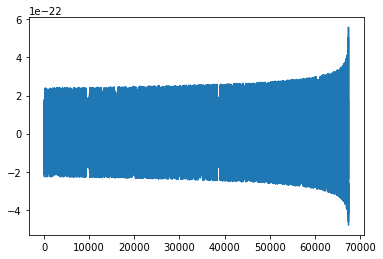

In [17]:
wv = MYwfgen(M,m,a,p0,e0,1.,qS,phiS,qK,phiK,dist,T=5)
wvp = PROCAwfgen(M,m,mu, a,p0,e0,1.,qS=qS,phiS=phiS,qK=qK,phiK=phiK,dist=dist,T=T, dt=dt)
plt.plot(wv.real)

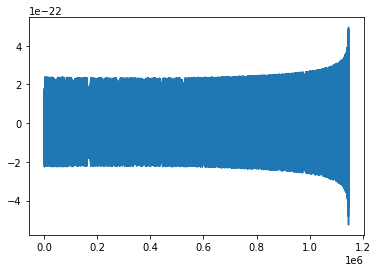

In [20]:
plt.plot(np.arange(len(wvp))*dt,wvp.real)